In [6]:
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple, to_plot
from snn_delays.utils.test_behavior import tb_addtask_refact
# from snn_delays.utils.visualization_utils import plot_taus
import numpy as np
device = get_device()

Running on: cuda:0


In [7]:
time_window = 50
batch_size = 32 # 128: anil kag

ckpt_dir = 'multiaddtask_04_2025_tests'

dataset = 'copymemory_episodic'

num_epochs = 5000 # important: epochs here refer to iteration steps

dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()
dataset_dict["time_ms"] = 2e3

for img, lbl in train_loader:
    print(img.shape)
    print(lbl.shape)
    break

Initializing GPU cache for 160000 samples...
Cache initialized in 14.87 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.01 seconds
torch.Size([32, 50, 3])
torch.Size([32, 5, 5])


In [8]:
num_h = 64

tau_m = 'log-uniform-st'

extra_kwargs = {'multifeedforward':3}
snn_f = SNN(dataset_dict, structure=(num_h, 2, 'mf'), win=time_window, tau_m=tau_m,
             loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_f.set_layers()
snn_f.to(device)

snn_rnn = SNN(dataset_dict, structure=(num_h, 2, 'r'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False)

snn_rnn.set_layers()
snn_rnn.to(device)

extra_kwargs = {'delay_range':(18, 1),
                'pruned_delays': 3}

snn_rd = SNN(dataset_dict, structure=(num_h, 2, 'd'), win=time_window, tau_m=tau_m,
               loss_fn='mem_prediction', batch_size=batch_size, device=device, debug=False, **extra_kwargs)

snn_rd.set_layers()
snn_rd.to(device)

Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms


SNN(
  (criterion): MSELoss()
  (layers): ModuleList(
    (0): FeedforwardSNNLayer(
      (linear): Linear(in_features=3, out_features=64, bias=False)
    )
    (1): FeedforwardSNNLayer(
      (linear): Linear(in_features=1152, out_features=64, bias=False)
    )
    (2): FeedforwardSNNLayer(
      (linear): Linear(in_features=64, out_features=5, bias=False)
    )
  )
)

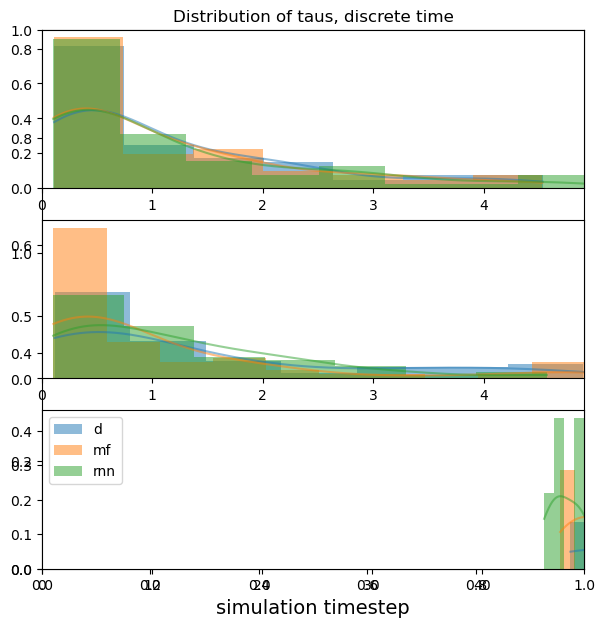

In [9]:
from snn_delays.utils.visualization_utils import plot_taus_refact, plot_param

import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot_taus_refact(snn_rd, label='d')
plot_taus_refact(snn_f, label='mf')
plot_taus_refact(snn_rnn, label='rnn')
plt.legend()

Frozen taus

In [10]:
lr_tau = 1.0
train(snn_f, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rnn, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)
train(snn_rd, train_loader, test_loader, 1e-3, 1, ckpt_dir=ckpt_dir, test_behavior=tb_addtask_refact, 
      scheduler=(100, 0.95), clear=True, lr_tau=lr_tau, printed_steps=100, freeze_taus=True)

Epoch [1/1], learning_rates 0.001000, 1.000000
Step [50/5000], Loss: 0.07289
Step [100/5000], Loss: 0.06762
Step [150/5000], Loss: 0.07186
Step [200/5000], Loss: 0.06579
Step [250/5000], Loss: 0.06037
Step [300/5000], Loss: 0.05669
Step [350/5000], Loss: 0.05358
Step [400/5000], Loss: 0.05859
Step [450/5000], Loss: 0.06027
Step [500/5000], Loss: 0.04408
Step [550/5000], Loss: 0.04673
Step [600/5000], Loss: 0.04948
Step [650/5000], Loss: 0.04812
Step [700/5000], Loss: 0.04049
Step [750/5000], Loss: 0.03723
Step [800/5000], Loss: 0.04028
Step [850/5000], Loss: 0.03465
Step [900/5000], Loss: 0.03876
Step [950/5000], Loss: 0.04693
Step [1000/5000], Loss: 0.03739
Step [1050/5000], Loss: 0.03281
Step [1100/5000], Loss: 0.02371
Step [1150/5000], Loss: 0.03644
Step [1200/5000], Loss: 0.03047
Step [1250/5000], Loss: 0.02550
Step [1300/5000], Loss: 0.03017
Step [1350/5000], Loss: 0.02736
Step [1400/5000], Loss: 0.02492
Step [1450/5000], Loss: 0.03044
Step [1500/5000], Loss: 0.02480
Step [1550/50

Text(0.5, 1.0, 'train loss')

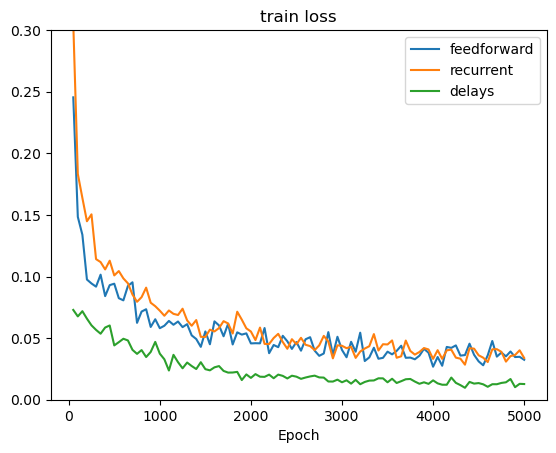

In [11]:
import numpy as np
from snn_delays.utils.visualization_utils import plot_per_epoch
import matplotlib.pyplot as plt
loss_error = np.mean(np.array(snn_f.train_loss)[:,1][-100:])
plot_per_epoch(snn_f.train_loss, label = 'feedforward')
plot_per_epoch(snn_rnn.train_loss, label = 'recurrent')
plot_per_epoch(snn_rd.train_loss, label = 'delays')
#plt.title(f'loss error = {loss_error}')

plt.ylim(0, 0.3)
plt.title('train loss')

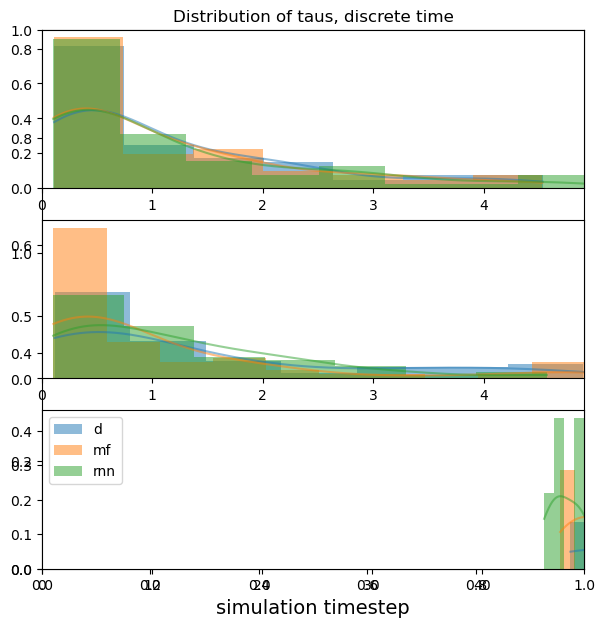

In [12]:
from snn_delays.utils.visualization_utils import plot_taus_refact
plt.figure(figsize=(7,7))
plot_taus_refact(snn_rd, label='d')
plot_taus_refact(snn_f, label='mf')
plot_taus_refact(snn_rnn, label='rnn')
plt.legend()

In [13]:
snn_f.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_f.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()

from snn_delays.utils.train_utils_refact_minimal import propagate_batch_simple
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
_, labels_rnn = propagate_batch_simple(snn_rnn, test_loader)
_, labels_rd = propagate_batch_simple(snn_rd, test_loader)

In [16]:
ref_mf = labels_mf[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_mf = snn_f.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rnn = labels_rnn[:,:int(0.1*time_window), :].permute(1, 0, 2).cpu().numpy()
out_rnn = snn_rnn.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

ref_rd = labels_rd[:,:int(0.1*time_window),:].permute(1, 0, 2).cpu().numpy()
out_rd = snn_rd.mem_state['output'][int(0.9*time_window):].detach().cpu().numpy()

from snn_delays.utils.visualization_utils import plot_add_task, plot_add_task2, plot_add_task3, plot_add_task4
# Create a figure with 3 rows and N columns (for stacking results horizontally)

def plot_add_task(output, reference, N, axes=None, name=''):

    ns = 50 # num samples to display for better viz

    ref = reference[:, :ns , N]
    out = output[:, :ns , N]
    diff = abs(ref-out)

    print(np.mean(diff))

    if axes is None:
        fig, axes = plt.subplots(3, 1, figsize=(5, 10))  # Create a new figure if axes not provided

    axes[0].imshow(ref, vmin=0, vmax=0.9)
    axes[0].set_title('Reference '+name)
    axes[0].set_ylabel('Time')

    axes[1].imshow(out, vmin=0, vmax=0.9)
    axes[1].set_title('Output')
    axes[1].set_ylabel('Time')

    axes[2].imshow(diff, vmin=0.0, vmax=0.5)
    axes[2].set_title('Difference')
    axes[2].set_ylabel('Time')
    axes[2].set_xlabel('Training Sample')

    return axes  # Return the axes to be used in an external figure

0.12408632
0.1510571
0.09506252


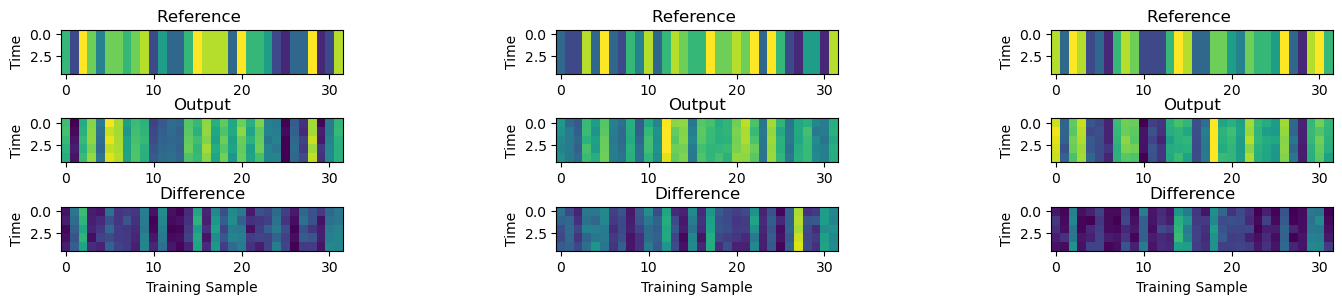

0.15008977
0.15688872
0.084745854


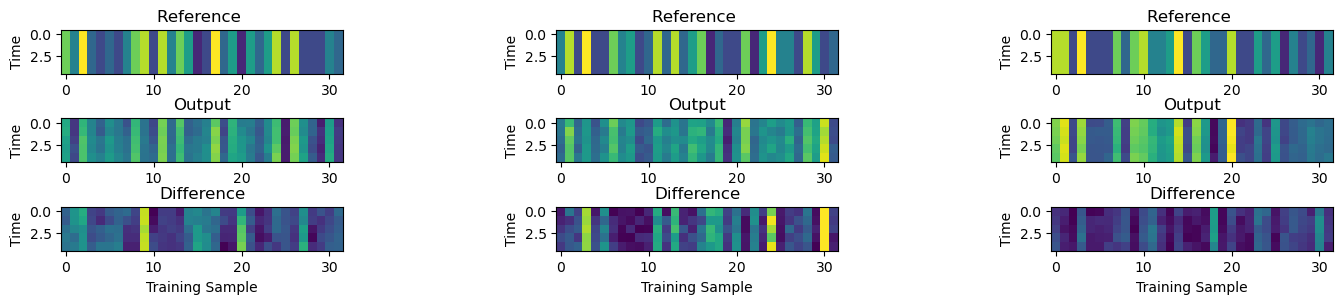

0.16147998
0.14743415
0.08333253


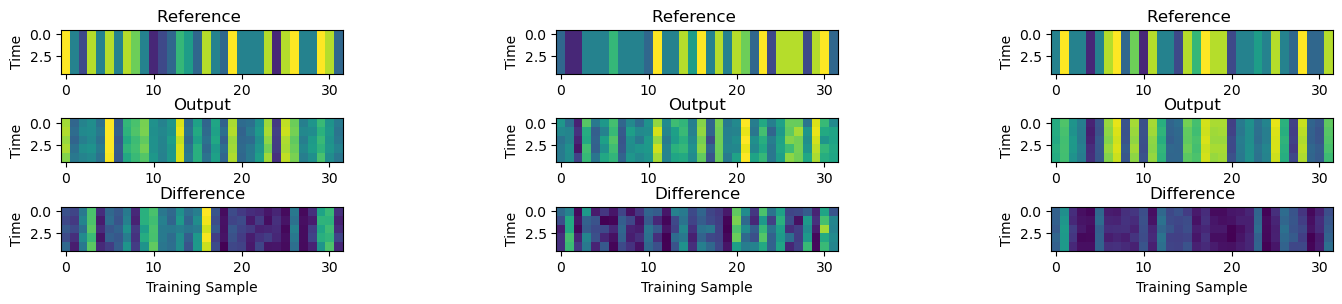

0.13550356
0.15917465
0.085187174


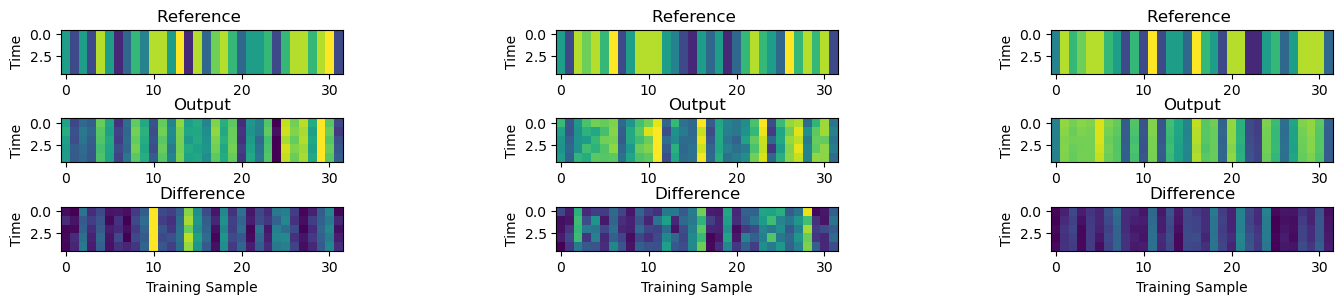

0.11723435
0.108717605
0.09042178


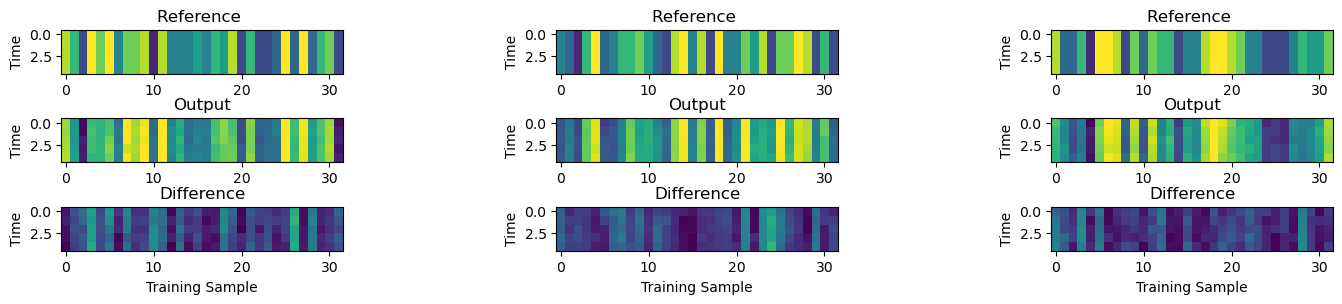

In [17]:
for out_neuron in range(5):

    fig, axes = plt.subplots(3, 3, figsize=(15, 3))  # 3 rows, 2 columns

    plot_add_task(out_mf, ref_mf, out_neuron, axes[:, 0])  
    plot_add_task(out_rnn, ref_rnn, out_neuron, axes[:, 1])  
    plot_add_task(out_rd, ref_rd, out_neuron, axes[:, 2])  

    plt.tight_layout()
    plt.show()

In [39]:
dataset = 'copymemory_episodic'

num_epochs = 1 # important: epochs here refer to iteration steps
dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window, shuffle=False)

Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.01 seconds


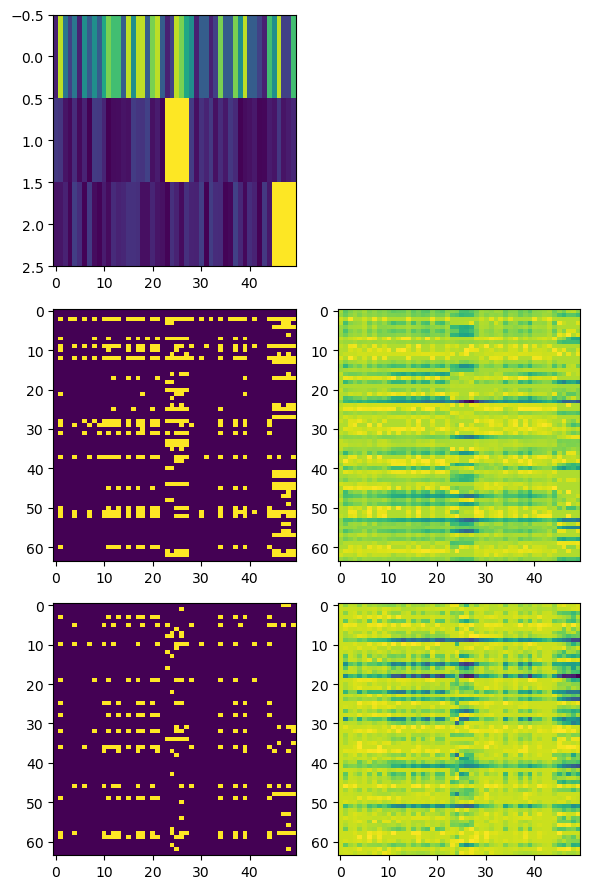

In [81]:
images, labels_mf = propagate_batch_simple(snn_f, test_loader)
spk = snn_f.spike_state
mem = snn_f.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

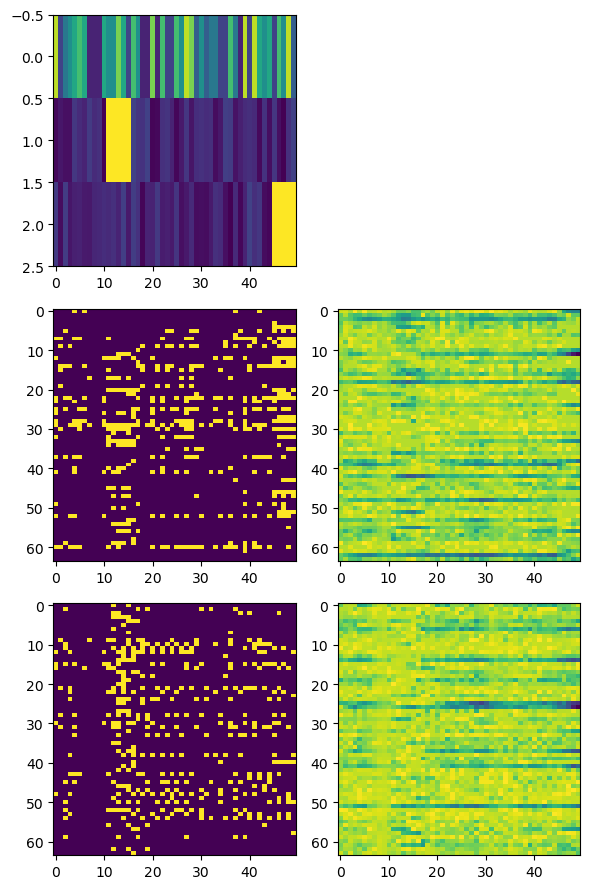

In [84]:
images, labels = propagate_batch_simple(snn_rnn, test_loader)
spk = snn_rnn.spike_state
mem = snn_rnn.mem_state
N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

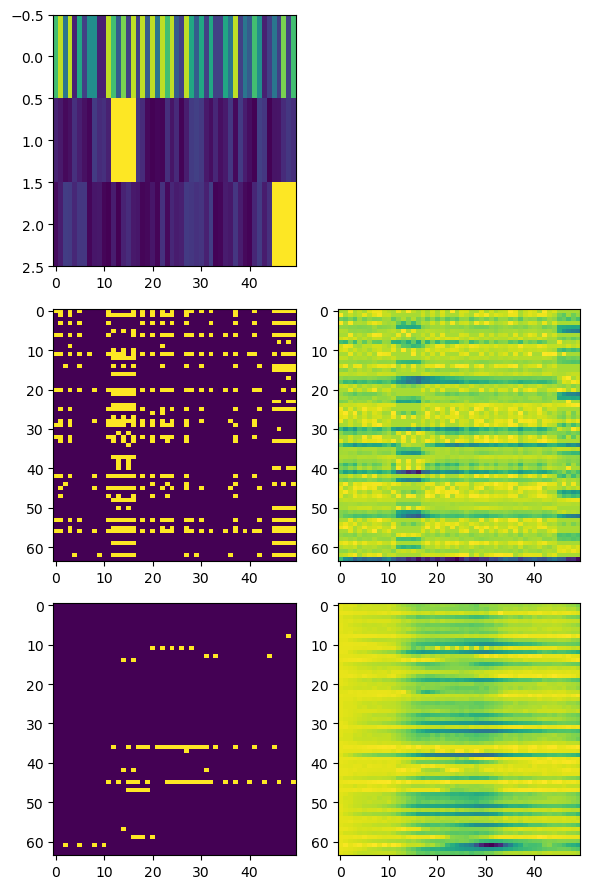

In [85]:
images, labels = propagate_batch_simple(snn_rd, test_loader)
spk = snn_rd.spike_state
mem = snn_rd.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()

Save models

In [90]:
import os
from snn_delays.config import CHECKPOINT_PATH
import torch

def save_model(snn, model_name='rsnn', directory='default'):
    """
    Function to save model

    :param model_name: Name of the model (default = 'rsnn')
    :param directory: Directory to save the model (relative to
    CHECKPOINT_PATH) (default = 'default')
    """

    snn.kwargs.pop('__class__', None)
    snn.kwargs.pop('self', None)
    snn.kwargs.pop('device', None)
    snn.kwargs.pop('debug', None)

    # Create the state dictionary
    state = {
        'type': type(snn),
        'net': snn.state_dict(),
        'epoch': snn.epoch,
        'acc_record': snn.acc,
        'train_loss': snn.train_loss,
        'test_loss': snn.test_loss,
        'test_spk': snn.test_spk_count,
        'model_name': snn.model_name,
        'self.info': snn.info,
        'kwargs': snn.kwargs
    }

    # Define the path to save the model
    model_path = os.path.join(CHECKPOINT_PATH, directory)

    # If the directory do not exist, it is created
    if not os.path.isdir(model_path):
        os.makedirs(model_path)

    # Save the model
    torch.save(state,
                os.path.join(model_path, model_name),
                _use_new_zipfile_serialization=False)
    print('Model saved in ', model_path)

ckpt_dir = 'copy-memory-st'
save_model(snn_rd, 'snn_rd', ckpt_dir)
save_model(snn_rnn, 'snn_rnn', ckpt_dir)
save_model(snn_f, 'snn_mf', ckpt_dir)

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\copy-memory-st
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\copy-memory-st
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\copy-memory-st


In [102]:
snn_rd.kwargs

{'self': SNN(
   (criterion): MSELoss()
   (layers): ModuleList(
     (0): RecurrentSNNLayer(
       (linear): Linear(in_features=3, out_features=64, bias=False)
       (linear_rec): Linear(in_features=64, out_features=64, bias=False)
     )
     (1): RecurrentSNNLayer(
       (linear): Linear(in_features=64, out_features=64, bias=False)
       (linear_rec): Linear(in_features=64, out_features=64, bias=False)
     )
     (2): FeedforwardSNNLayer(
       (linear): Linear(in_features=64, out_features=5, bias=False)
     )
   )
 ),
 'dataset_dict': {'num_input': 3,
  'num_training_samples': 160000,
  'num_output': 5,
  'dataset_name': 'copymemory_episodic',
  'time_ms': 2000.0},
 'structure': (64, 2, 'r'),
 'tau_m': 'log-uniform-st',
 'win': 50,
 'loss_fn': 'mem_prediction',
 'batch_size': 32,
 'device': 'cuda',
 'extra_kwargs': {'extra_kwargs': {'debug': False}},
 '__class__': snn_delays.snn_refactored.SNN}

In [3]:
from snn_delays.utils.model_loader_refac import ModelLoader
ckpt_dir = 'copy-memory-st'
snn_mf = ModelLoader('snn_mf', ckpt_dir, 32, 'cuda')
snn_rnn = ModelLoader('snn_rnn', ckpt_dir, 32, 'cuda')
snn_rd = ModelLoader('snn_rd', ckpt_dir, 32, 'cuda')

Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Delta t: 40.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [11]:
from snn_delays.utils.dataset_loader import DatasetLoader

dataset = 'copymemory_episodic'
batch_size = 32
time_window = 50
num_epochs = 1 # important: epochs here refer to iteration steps
dataset_size = batch_size*num_epochs

DL = DatasetLoader(dataset=dataset, caching='gpu', 
                   dataset_size = dataset_size,
                   num_workers=0, batch_size=batch_size, 
                   total_time=time_window, shuffle=False)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds
Initializing GPU cache for 32 samples...
Cache initialized in 0.00 seconds


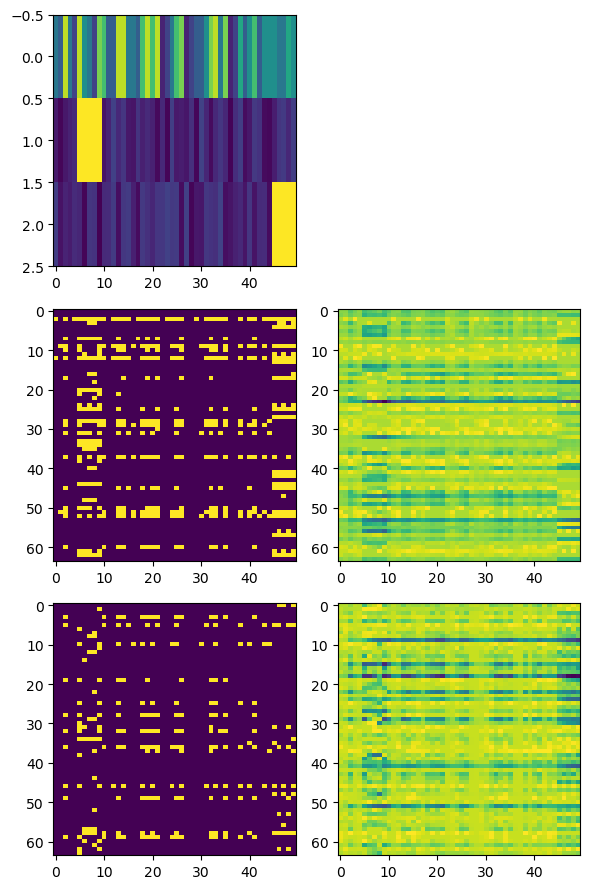

In [14]:
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
import matplotlib.pyplot as plt

snn_mf.debug = True
snn_rnn.debug = True
snn_rd.debug = True
snn_mf.init_state_logger()
snn_rnn.init_state_logger()
snn_rd.init_state_logger()

images, labels_mf = propagate_batch_simple(snn_mf, test_loader)
spk = snn_mf.spike_state
mem = snn_mf.mem_state

N = 0

plt.figure(figsize=(6,9))

plt.subplot(321)
plt.imshow(images[N].T.cpu().numpy(), aspect='auto')

plt.subplot(323, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(325, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(spk['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(324, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l1'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.subplot(326, sharex=plt.gca())  # Share x-axis with current axes
plt.imshow(mem['l2'][:, N, :].T.detach().cpu().numpy(), aspect='auto')

plt.tight_layout()
plt.show()